C:\Users\user\AppData\Local\Temp\ipykernel_1696\442795106.py:39: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv(file_path, parse_dates={'datetime': ['Tanggal', 'Waktu']}, dayfirst=True, infer_datetime_format=True)
C:\Users\user\AppData\Local\Temp\ipykernel_1696\442795106.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv(file_path, parse_dates={'datetime': ['Tanggal', 'Waktu']}, dayfirst=True, infer_datetime_format=True)


Epoch 1/100
228/228 [==============================] - 6s 9ms/step - loss: 0.1326 - val_loss: 0.0116
Epoch 2/100
228/228 [==============================] - 2s 8ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 3/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0126
Epoch 4/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 5/100
228/228 [==============================] - 2s 7ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 6/100
228/228 [==============================] - 3s 12ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 7/100
228/228 [==============================] - 2s 8ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 8/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 10/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0102 - val_l

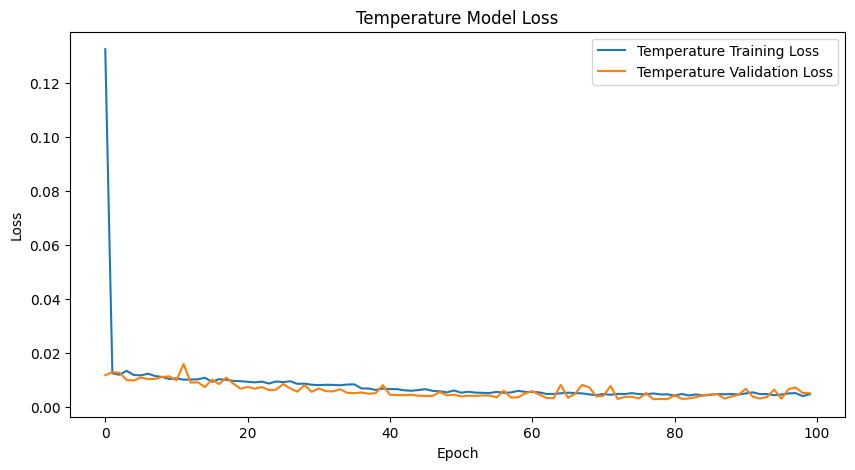

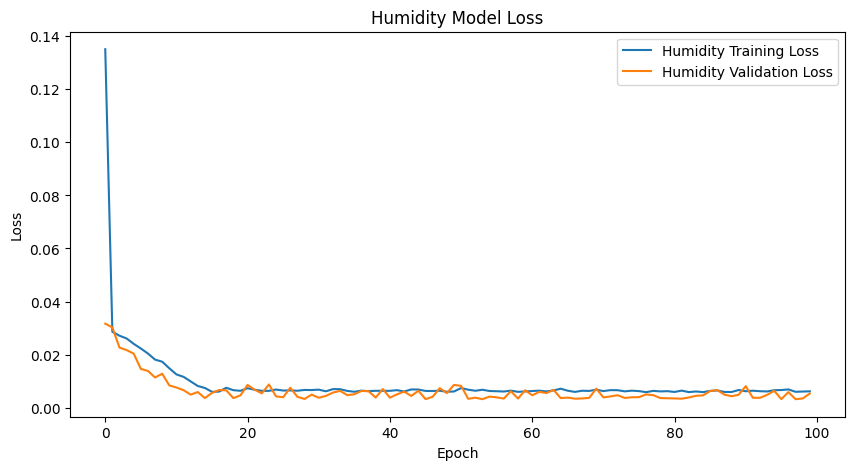

Temperature Train RMSE: 0.545
Temperature Test RMSE: 0.261
Humidity Train RMSE: 1.537
Humidity Test RMSE: 0.716


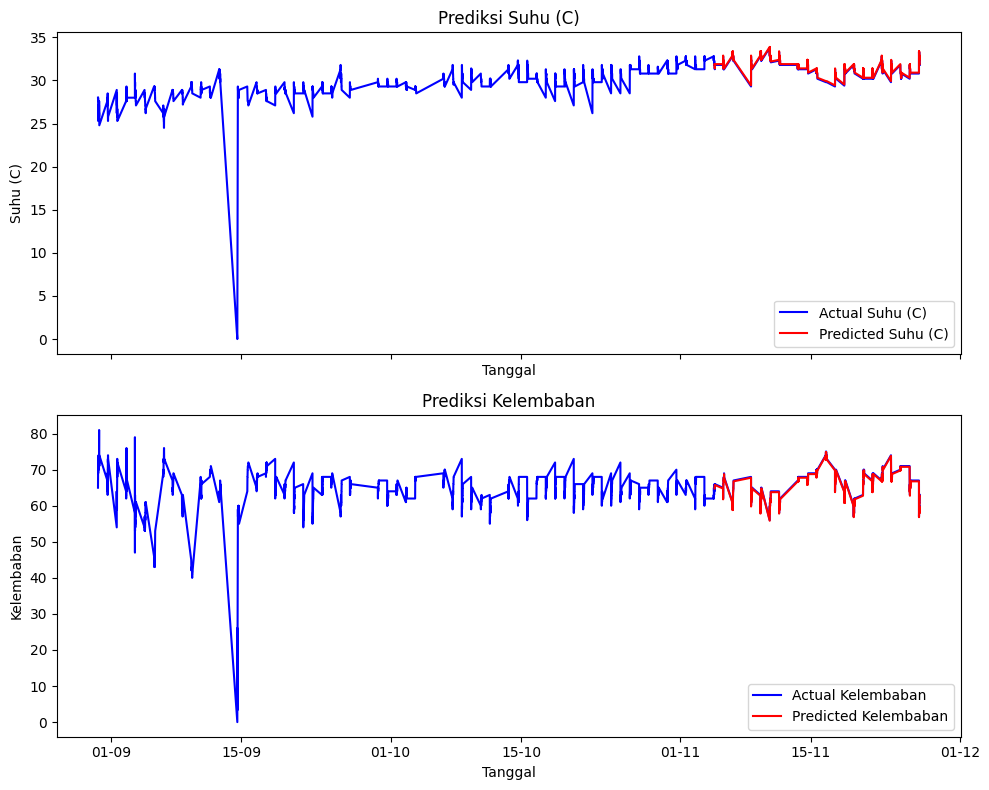

In [1]:
import os
from math import sqrt
from numpy import concatenate, random
from matplotlib import pyplot as plt
from pandas import read_csv, DataFrame, to_datetime, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

random.seed(7)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Read dataset
file_path = 'Dataset Sensor Kel2.txt'  # Replace with your file path
dataset = read_csv(file_path, parse_dates={'datetime': ['Tanggal', 'Waktu']}, dayfirst=True, infer_datetime_format=True)
dataset['datetime'] = to_datetime(dataset['datetime'], format='%d/%m/%Y %H.%M.%S')
dataset['Bulan'] = dataset['datetime'].dt.month

# Select features for temperature and humidity
features_to_predict_temperature = ['Suhu (C)']
features_to_predict_humidity = ['Kelembaban']

# Normalize features using MinMaxScaler
scaler_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_humidity = MinMaxScaler(feature_range=(0, 1))

scaled_values_temperature = scaler_temperature.fit_transform(dataset[features_to_predict_temperature])
scaled_values_humidity = scaler_humidity.fit_transform(dataset[features_to_predict_humidity])

# Prepare temperature dataset
reframed_temperature = series_to_supervised(scaled_values_temperature, 1, 1)
reframed_temperature.drop(reframed_temperature.columns[2:], axis=1, inplace=True)
values_temperature = reframed_temperature.values
n_train_temperature = int(len(dataset) * 0.75)
train_temperature = values_temperature[:n_train_temperature, :]
test_temperature = values_temperature[n_train_temperature:, :]
train_x_temperature, train_y_temperature = train_temperature[:, :-1], train_temperature[:, -1]
test_x_temperature, test_y_temperature = test_temperature[:, :-1], test_temperature[:, -1]
train_x_temperature = train_x_temperature.reshape((train_x_temperature.shape[0], 1, train_x_temperature.shape[1]))
test_x_temperature = test_x_temperature.reshape((test_x_temperature.shape[0], 1, test_x_temperature.shape[1]))

# Design and train LSTM model for temperature
model_temperature = Sequential()
model_temperature.add(LSTM(150, input_shape=(train_x_temperature.shape[1], train_x_temperature.shape[2])))
model_temperature.add(Dense(units=1))
model_temperature.compile(loss='mae', optimizer='adam')
history_temperature = model_temperature.fit(train_x_temperature, train_y_temperature, epochs=100, batch_size=32,
                                           validation_data=(test_x_temperature, test_y_temperature), verbose=1, shuffle=False)

# Make predictions for temperature
yhat_train_temperature = model_temperature.predict(train_x_temperature)
train_x_temperature = train_x_temperature.reshape((train_x_temperature.shape[0], train_x_temperature.shape[2]))
inv_yhat_train_temperature = scaler_temperature.inverse_transform(
    concatenate((yhat_train_temperature, train_x_temperature[:, 1:]), axis=1))
inv_yhat_train_temperature = inv_yhat_train_temperature[:, 0]
train_y_temperature = train_y_temperature.reshape((len(train_y_temperature), 1))
inv_y_train_temperature = scaler_temperature.inverse_transform(
    concatenate((train_y_temperature, train_x_temperature[:, 1:]), axis=1))
inv_y_train_temperature = inv_y_train_temperature[:, 0]

yhat_test_temperature = model_temperature.predict(test_x_temperature)
test_x_temperature = test_x_temperature.reshape((test_x_temperature.shape[0], test_x_temperature.shape[2]))
inv_yhat_test_temperature = scaler_temperature.inverse_transform(
    concatenate((yhat_test_temperature, test_x_temperature[:, 1:]), axis=1))
inv_yhat_test_temperature = inv_yhat_test_temperature[:, 0]
test_y_temperature = test_y_temperature.reshape((len(test_y_temperature), 1))
inv_y_test_temperature = scaler_temperature.inverse_transform(
    concatenate((test_y_temperature, test_x_temperature[:, 1:]), axis=1))
inv_y_test_temperature = inv_y_test_temperature[:, 0]

# Prepare humidity dataset
reframed_humidity = series_to_supervised(scaled_values_humidity, 1, 1)
reframed_humidity.drop(reframed_humidity.columns[2:], axis=1, inplace=True)
values_humidity = reframed_humidity.values
n_train_humidity = int(len(dataset) * 0.75)
train_humidity = values_humidity[:n_train_humidity, :]
test_humidity = values_humidity[n_train_humidity:, :]
train_x_humidity, train_y_humidity = train_humidity[:, :-1], train_humidity[:, -1]
test_x_humidity, test_y_humidity = test_humidity[:, :-1], test_humidity[:, -1]
train_x_humidity = train_x_humidity.reshape((train_x_humidity.shape[0], 1, train_x_humidity.shape[1]))
test_x_humidity = test_x_humidity.reshape((test_x_humidity.shape[0], 1, test_x_humidity.shape[1]))

# Design and train LSTM model for humidity
model_humidity = Sequential()
model_humidity.add(LSTM(150, input_shape=(train_x_humidity.shape[1], train_x_humidity.shape[2])))
model_humidity.add(Dense(units=1))
model_humidity.compile(loss='mae', optimizer='adam')
history_humidity = model_humidity.fit(train_x_humidity, train_y_humidity, epochs=100, batch_size=32,
                                      validation_data=(test_x_humidity, test_y_humidity), verbose=1, shuffle=False)

# Make predictions for humidity
yhat_train_humidity = model_humidity.predict(train_x_humidity)
train_x_humidity = train_x_humidity.reshape((train_x_humidity.shape[0], train_x_humidity.shape[2]))
inv_yhat_train_humidity = scaler_humidity.inverse_transform(
    concatenate((yhat_train_humidity, train_x_humidity[:, 1:]), axis=1))
inv_yhat_train_humidity = inv_yhat_train_humidity[:, 0]
train_y_humidity = train_y_humidity.reshape((len(train_y_humidity), 1))
inv_y_train_humidity = scaler_humidity.inverse_transform(
    concatenate((train_y_humidity, train_x_humidity[:, 1:]), axis=1))
inv_y_train_humidity = inv_y_train_humidity[:, 0]

yhat_test_humidity = model_humidity.predict(test_x_humidity)
test_x_humidity = test_x_humidity.reshape((test_x_humidity.shape[0], test_x_humidity.shape[2]))
inv_yhat_test_humidity = scaler_humidity.inverse_transform(
    concatenate((yhat_test_humidity, test_x_humidity[:, 1:]), axis=1))
inv_yhat_test_humidity = inv_yhat_test_humidity[:, 0]
test_y_humidity = test_y_humidity.reshape((len(test_y_humidity), 1))
inv_y_test_humidity = scaler_humidity.inverse_transform(
    concatenate((test_y_humidity, test_x_humidity[:, 1:]), axis=1))
inv_y_test_humidity = inv_y_test_humidity[:, 0]

# Plot Model Loss for temperature
plt.figure(figsize=(10, 5))
plt.plot(history_temperature.history['loss'], label='Temperature Training Loss')
plt.plot(history_temperature.history['val_loss'], label='Temperature Validation Loss')
plt.title('Temperature Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Model Loss for humidity
plt.figure(figsize=(10, 5))
plt.plot(history_humidity.history['loss'], label='Humidity Training Loss')
plt.plot(history_humidity.history['val_loss'], label='Humidity Validation Loss')
plt.title('Humidity Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate RMSE for temperature and humidity
rmse_train_temperature = sqrt(mean_squared_error(inv_y_train_temperature, inv_yhat_train_temperature))
print('Temperature Train RMSE: %.3f' % rmse_train_temperature)

rmse_test_temperature = sqrt(mean_squared_error(inv_y_test_temperature, inv_yhat_test_temperature))
print('Temperature Test RMSE: %.3f' % rmse_test_temperature)

rmse_train_humidity = sqrt(mean_squared_error(inv_y_train_humidity, inv_yhat_train_humidity))
print('Humidity Train RMSE: %.3f' % rmse_train_humidity)

rmse_test_humidity = sqrt(mean_squared_error(inv_y_test_humidity, inv_yhat_test_humidity))
print('Humidity Test RMSE: %.3f' % rmse_test_humidity)

# Plot the results for temperature
x0_temperature = list(range(len(train_y_temperature)))
x1_temperature = list(range(len(train_y_temperature), len(train_y_temperature) + len(test_y_temperature)))

fig_temperature, (ax1_temperature, ax2_temperature) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot for Suhu (C)
ax1_temperature.plot(dataset['datetime'], dataset['Suhu (C)'], 'b', label='Actual Suhu (C)')
ax1_temperature.plot(dataset['datetime'].iloc[x1_temperature], inv_yhat_test_temperature, 'r', label='Predicted Suhu (C)')
ax1_temperature.set_ylabel('Suhu (C)')
ax1_temperature.set_xlabel('Tanggal')
ax1_temperature.set_title('Prediksi Suhu (C)')
ax1_temperature.legend()

# Plot for Kelembaban
ax2_temperature.plot(dataset['datetime'], dataset['Kelembaban'], 'b', label='Actual Kelembaban')
ax2_temperature.plot(dataset['datetime'].iloc[x1_temperature], inv_yhat_test_humidity, 'r', label='Predicted Kelembaban')
ax2_temperature.set_ylabel('Kelembaban')
ax2_temperature.set_xlabel('Tanggal')
ax2_temperature.set_title('Prediksi Kelembaban')
ax2_temperature.legend()

ax1_temperature.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
ax2_temperature.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))

plt.tight_layout()
plt.show()
